# Anomaly detection 1

In this notebook we are going to perform anomaly detection on the dataset data_clean.xlsx using : Z-score, iForest, OneClassSVM and DBSCAN. We are going to detect anomalies for each mediaType separately and based on the "data" column alone

In [1]:
#Import necessary libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.ensemble import IsolationForest
from numpy import where
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

In [2]:
#Load data

file_name = ".\\data_clean.xlsx"
xl_file = pd.ExcelFile(file_name,engine = 'openpyxl')
df = xl_file.parse('Sheet1')

## Data preprocessing 

In [3]:
## Null values 

df_null = df[df['data'].isnull()]
df.dropna(subset=['data'], inplace=True)

In [4]:
print('the percentage of missing data : ', round((len(df_null)/len(df))*100,2),'%')

the percentage of missing data :  2.37 %


In [5]:
print('the number of locations with missing data : ',len(list(df_null.Location_.unique())))
print('the number of mediaTypes with missing data : ',len(list(df_null.mediaType.unique())))
#print(list(anomalies.meterId.unique()))
print('the number of meterIds with missing data : ',len(list(df_null.meterId.unique())))
# print(anomalies['Location_'].value_counts())

the number of locations with missing data :  20
the number of mediaTypes with missing data :  8
the number of meterIds with missing data :  95


In [6]:
# df.isna().sum()

In [7]:
##Handling units

# We are going to convert everything that is MWh to KWh and  Nm³ , CCF , l, kl to m³

df['unit']=df['unit'].astype('string')

#df2 = df
#print(len(df2[df2['unit']=='MWh']))
for i, row in df.iterrows():
    # 1MWh = 1000KWh
    if row['unit'] == 'MWh':
        df.at[i, 'data'] = row['data']*1000
        df.at[i, 'unit'] = 'kWh'

    #we will consider that we work in stadard condition (T=273.15K et P=101325 Pa) and 1Nm³ = 1m³
    if row['unit'] == 'Nm³':
        df.at[i, 'unit'] = 'm³'

    # 1CCF = 2,83m³
    if row['unit'] == 'CCF':
        df.at[i, 'data'] = row['data']*2.83
        df.at[i, 'unit'] = 'm³'    

    # 1l = 0.001m³
    if row['unit'] == 'l':
        df.at[i, 'data'] = row['data']*0.001
        df.at[i, 'unit'] = 'm³'

    #1kl = 1m³
    if row['unit'] == 'kl':
        df.at[i, 'unit'] = 'm³'

    #1ft³ = 0,0283m³
    if row['unit'] == 'ft³':
        df.at[i, 'data'] = row['data']*0.0283
        df.at[i, 'unit'] = 'm³'

    #1therm = 2,851m³
    if row['unit'] == 'therm':
        df.at[i, 'data'] = row['data']*2.851
        df.at[i, 'unit'] = 'm³'

print("The different units are : ")        
print(list(df.unit.unique()))

The different units are : 
['kWh', 'm³', 'kW', 'kVArh', 'GJ']


In [9]:
## the list of mediaTypes
print('list of media types : ')
list(df.mediaType.unique())

list of media types : 


['Electricity',
 'Heating',
 'ColdWater',
 'WS_Brunnenwasser',
 'Electricity1',
 'Electricity2',
 'Power',
 'WS_Blindstrom',
 'ElectricityGenEmergency',
 'ElectricityGenPV',
 'NGas',
 'GeneralElectricity',
 'DistrictHeating',
 'Cooling',
 'ElectricityGenCHP',
 'HeatGenCHP',
 'IntervalGas',
 'ColdGenerated',
 'ElectricitySupplyPV',
 'Diesel']

## 1 - Anomaly detection using statistics based approach

This method is based on the calculation of the Z-score; the z-score measures how far a data point is away from the mean as a signed multiple of the standard deviation. Large absolute values of the Z-score suggest an anomaly

In [10]:
groups = df.groupby(['mediaType'])

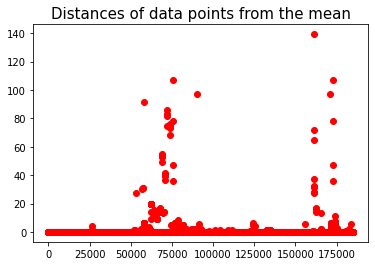

In [11]:
## Choose mediaType

mediaType = 'Electricity'

# Isolating data points that corrspond to the specified metiaType

group = groups.get_group(mediaType)
group = group.reset_index(drop=True)

# calculating and ploting the Z-score

X = group['data'].to_numpy()
distances = []
std = np.std(X)
mean = np.mean(X)

for e in X :
    d = abs(e-mean)/std
    distances.append(d)
    
plt.plot(distances,'ro')
plt.title("Distances of data points from the mean",fontsize = 15)

# Separating the anomalies

idxs = []

for i, element in enumerate(distances) :
    if element > 3 :
        idxs.append(i)
        
anomalies = group.filter(items = idxs, axis=0)
anomalies = anomalies.reset_index(drop=True)

In [12]:
print('the percentage of anomalies : ', round((len(anomalies)/len(group))*100,2),'%')

the percentage of anomalies :  0.07 %


In [13]:
print ("***The table of anomalies***")
display(anomalies)

***The table of anomalies***


,date,meterId,Country,mediaType,data,unit,Location_,meterType
0,2020-08-10,1263078,Portugal,Electricity,420347.39,kWh,Portugal,Sub 2
1,2021-07-10,2401061,India,Electricity,2843070.00,kWh,India kalwa,Submeter
2,2021-07-10,2407797,India,Electricity,3125370.00,kWh,India kalwa,Submeter
3,2021-10-10,2407797,India,Electricity,3225090.00,kWh,India kalwa,Submeter
4,2021-11-01,2407797,India,Electricity,3225100.00,kWh,India kalwa,Submeter
...,...,...,...,...,...,...,...,...
130,2021-11-23,6160580,India,Electricity,-545521.40,kWh,India kalwa,Submeter
131,2021-12-01,6160580,India,Electricity,-788343.25,kWh,India kalwa,Submeter
132,2021-12-15,6160580,India,Electricity,548301.49,kWh,India kalwa,Submeter
133,2021-12-24,6160580,India,Electricity,-536058.60,kWh,India kalwa,Submeter


In [16]:

print('the number of meterIds : ',anomalies.meterId.nunique(),'\n')
print('locations with anomalies : \n')
print(anomalies['Location_'].value_counts())

the number of meterIds :  34 

locations with anomalies : 

India kalwa    129
Portugal         4
India GU         2
Name: Location_, dtype: int64


In [17]:
print('locations with anomalies and their percentage : \n')
print(anomalies['Location_'].value_counts().index,'\n')
print(np.round(anomalies['Location_'].value_counts().to_numpy()*100,2)/len(anomalies))

locations with anomalies and their percentage : 

Index(['India kalwa', 'Portugal', 'India GU'], dtype='object') 

[95.55555556  2.96296296  1.48148148]


## 2 - Anomaly detection using Isolation Forest

- This algorithm requires a parameter called “contamination” that refers to the fraction of anomalies estimated in the data, we are going to estimate this parameter based on the results of the previous method 
- The other hyperparameters of the used model : n_estimators=50, max_samples='auto', max_features=1.0,random_state=42


In [18]:
## Estimating the contamination coefficient using the results of the previous method

anomaly_percentage = [0.0007,0.0266,0.0001,0.0382,0.0001,0.0001,0.0004,0.0001,0.0031,0.0023,0.0016,0.0003,0.0011,0.0109,0,0,0.0001,0.0339,0.0342,0.0001]

mediaTypes = list(df.mediaType.unique())


In [19]:
## Choose mediaType

mediaType = 'Electricity'

# Isolating data points that corrspond to the specified metiaType

group = groups.get_group(mediaType)
group = group.reset_index(drop=True)

# calculating and ploting the Z-score

X = group['data'].to_numpy()
X = X.reshape(-1, 1)
c = anomaly_percentage[mediaTypes.index(mediaType)]

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(c),max_features=1.0,random_state=42)
pred = model.fit_predict(X)
idxs = []

for i, e in enumerate(pred):
    if e == -1 :
        idxs.append(i)

anomalies = group.filter(items = idxs, axis=0)
anomalies = anomalies.reset_index(drop=True)
print ("***The table of anomalies***")
display(anomalies)

***The table of anomalies***


,date,meterId,Country,mediaType,data,unit,Location_,meterType
0,2020-08-10,1263078,Portugal,Electricity,420347.39,kWh,Portugal,Sub 2
1,2021-07-10,2401061,India,Electricity,2843070.00,kWh,India kalwa,Submeter
2,2021-07-10,2407795,India,Electricity,172710.00,kWh,India kalwa,Submeter
3,2021-12-12,2407795,India,Electricity,248410.00,kWh,India kalwa,Submeter
4,2021-07-10,2407797,India,Electricity,3125370.00,kWh,India kalwa,Submeter
...,...,...,...,...,...,...,...,...
118,2021-12-01,5867412,India,Electricity,180465.41,kWh,India kalwa,Submeter
119,2021-12-24,5867412,India,Electricity,183252.86,kWh,India kalwa,Submeter
120,2021-12-15,6160580,India,Electricity,548301.49,kWh,India kalwa,Submeter
121,2021-12-24,6181237,India,Electricity,258134.43,kWh,India kalwa,Submeter


In [20]:
print('the percentage of anomalies : ', round((len(anomalies)/len(group))*100,2),'%')

the percentage of anomalies :  0.07 %


In [22]:
print('the number of meterIds : ',anomalies.meterId.nunique(),'\n')
print('locations with anomalies : \n')
print(anomalies['Location_'].value_counts())

the number of meterIds :  34 

locations with anomalies : 

India kalwa        118
Portugal             2
India GU             2
Switzerland Zug      1
Name: Location_, dtype: int64


In [23]:
print('locations with anomalies and their percentage : \n')
print(anomalies['Location_'].value_counts().index,'\n')
print(np.round(anomalies['Location_'].value_counts().to_numpy()*100,2)/len(anomalies))

locations with anomalies and their percentage : 

Index(['India kalwa', 'Portugal', 'India GU', 'Switzerland Zug'], dtype='object') 

[95.93495935  1.62601626  1.62601626  0.81300813]


## 2 - Anomaly detection using One Class SVM

- This algorithm requires a parameter “nu” that specifies an approximation ratio of the outliers in the dataset, we are going to estimate this parameter in the same way we did for the “contamination”
- The other hyperparameters of the used model are the default ones


In [24]:
## Choose mediaType

mediaType = 'Diesel'

# Isolating data points that corrspond to the specified metiaType

group = groups.get_group(mediaType)
group = group.reset_index(drop=True)

# calculating and ploting the Z-score

X = group['data'].to_numpy()
X = X.reshape(-1, 1)
c = anomaly_percentage[mediaTypes.index(mediaType)]

model = OneClassSVM(nu=float(c))
pred = model.fit_predict(X)
idxs = []

for i, e in enumerate(pred):
    if e == -1 :
        idxs.append(i)

anomalies = group.filter(items = idxs, axis=0)
anomalies = anomalies.reset_index(drop=True)
print ("***The table of anomalies***")
display(anomalies)

***The table of anomalies***


,date,meterId,Country,mediaType,data,unit,Location_,meterType
0,2022-04-01,6437924,India,Diesel,0.01,m³,India BL,Main meter
1,2022-04-02,6437924,India,Diesel,0.01,m³,India BL,Main meter
2,2022-04-03,6437924,India,Diesel,0.01,m³,India BL,Main meter
3,2022-04-04,6437924,India,Diesel,0.01,m³,India BL,Main meter
4,2022-04-05,6437924,India,Diesel,0.01,m³,India BL,Main meter
...,...,...,...,...,...,...,...,...
117,2022-04-26,6558104,India,Diesel,14.17,m³,India kalwa,Main meter
118,2022-04-27,6558104,India,Diesel,14.17,m³,India kalwa,Main meter
119,2022-04-28,6558104,India,Diesel,14.17,m³,India kalwa,Main meter
120,2022-04-29,6558104,India,Diesel,14.17,m³,India kalwa,Main meter


In [25]:
print('the percentage of anomalies : ', round((len(anomalies)/len(group))*100,2),'%')

the percentage of anomalies :  50.83 %


In [28]:
print('the number of meterIds : ',anomalies.meterId.nunique(),'\n')
print('locations with anomalies : \n')
print(anomalies['Location_'].value_counts())

the number of meterIds :  2 

locations with anomalies : 

India kalwa    92
India BL       30
Name: Location_, dtype: int64


In [29]:
print('locations with anomalies and their percentage : \n')
print(anomalies['Location_'].value_counts().index,'\n')
print(np.round(anomalies['Location_'].value_counts().to_numpy()*100,2)/len(anomalies))

locations with anomalies and their percentage : 

Index(['India kalwa', 'India BL'], dtype='object') 

[75.40983607 24.59016393]


## 3- Anomaly detection using BDSCAN

- This algorithm requires 2 parameters : min_samples and eps, that we set to min_samples = 2 and eps = 1 , using the previous results

In [30]:

## Choose mediaType

mediaType = 'Diesel'

# Isolating data points that corrspond to the specified metiaType

group = groups.get_group(mediaType)
group = group.reset_index(drop=True)

# calculating and ploting the Z-score

X = group['data'].to_numpy()
X = X.reshape(-1, 1)

model = DBSCAN(eps = 1, min_samples = 2, metric = 'euclidean').fit(X)
pred = model.fit_predict(X)
idxs = []

for i, e in enumerate(model.labels_):
    if e == -1 :
        idxs.append(i)

anomalies = group.filter(items = idxs, axis=0)
anomalies = anomalies.reset_index(drop=True)
anomalies

,date,meterId,Country,mediaType,data,unit,Location_,meterType


In [31]:
print('the percentage of anomalies : ',round((len(anomalies)/len(group))*100,2),'%')

the percentage of anomalies :  0.0 %


In [32]:
print('the number of meterIds : ',anomalies.meterId.nunique(),'\n')
print('locations with anomalies : \n')
print(anomalies['Location_'].value_counts())

the number of meterIds :  0 

locations with anomalies : 

Series([], Name: Location_, dtype: int64)


In [33]:
print('locations with anomalies and their percentage : \n')
print(anomalies['Location_'].value_counts().index,'\n')
print(np.round(anomalies['Location_'].value_counts().to_numpy()*100,2)/len(anomalies))

locations with anomalies and their percentage : 

Index([], dtype='object') 

[]
